# Prerequisites

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from geopy.distance import geodesic

# Data Cleanup

In [75]:
diary = pd.read_csv("./data-sources/flightdiary.csv", header=1)

#Gathering filenames
diary["PathFile"] = diary.Date.str[2:] + "-" + diary.FlightNumber

# Splitting airport information
diary["FromICAO"] = diary.From.str[-5:-1]
diary["FromIATA"] = diary.From.str[-9:-6]
diary["FromCity"] = diary.From.str.split("/").str[0]
diary.FromCity = diary.FromCity.str[:-1]
diary.From = diary.From.str.split("/").str[1]
diary.From = diary.From.str[:-5]
diary["ToICAO"] = diary.To.str[-5:-1]
diary["ToIATA"] = diary.To.str[-9:-6]
diary["ToCity"] = diary.To.str.split("/").str[0]
diary.ToCity = diary.ToCity.str[:-1]
diary.To = diary.To.str.split("/").str[1]
diary.To = diary.To.str[:-5]

# Splitting airline information
diary["AirlineICAO"] = diary.Airline.str[-4:-1]
diary["AirlineIATA"] = diary.Airline.str[-7:-5]
diary.Airline = diary.Airline.str[:-9]
diary["AirlineColor"] = diary.AirlineICAO

# Prettifying names of cities, airports and airlines
diary.FromCity = diary.FromCity.str.replace("Istanbul", "İstanbul").str.replace("Izmir", "İzmir").str.replace("Antakya", "Hatay").str.replace("Ercan", "Nicosia").str.replace("Tromso", "Tromsø").str.replace("Sharm el Sheikh", "Sharm El-Sheikh")
diary.ToCity = diary.ToCity.str.replace("Istanbul", "İstanbul").str.replace("Izmir", "İzmir").str.replace("Antakya", "Hatay").str.replace("Ercan", "Nicosia").str.replace("Tromso", "Tromsø").str.replace("Sharm el Sheikh", "Sharm El-Sheikh")
diary.From = diary.From.str.replace("Ataturk", "Atatürk").str.replace("Sabiha Gokcen", "Sabiha Gökçen").str.replace("Sakirpasa", "Şakirpaşa").str.replace("Hatay", "Antakya").str.replace("Carsamba", "Çarşamba").str.replace("Esenboga", "Esenboğa").str.replace("Sharm el-Sheik Intl", "Sharm El-Sheikh").str.replace("Mersin Cukurova International Airport", "Çukurova").str.replace("Nikola Tesla Beograd", "Nikola Tesla").str.replace("MR Stefanik", "M. R. Štefánik")
diary.To = diary.To.str.replace("Ataturk", "Atatürk").str.replace("Sabiha Gokcen", "Sabiha Gökçen").str.replace("Sakirpasa", "Şakirpaşa").str.replace("Hatay", "Antakya").str.replace("Carsamba", "Çarşamba").str.replace("Esenboga", "Esenboğa").str.replace("Sharm el-Sheik Intl", "Sharm El-Sheikh").str.replace("Mersin Cukurova International Airport", "Çukurova").str.replace("Nikola Tesla Beograd", "Nikola Tesla").str.replace("MR Stefanik", "M. R. Štefánik")
diary.Airline = diary.Airline.str.replace("Transavia.com France","Transavia").replace("Norwegian Air International","Norwegian Air").replace("Pegasus Airlines","Pegasus").replace("AJet Airlines","AJet")
diary.AirlineColor = diary.AirlineICAO.str.replace("THY", "#ff0000").str.replace("PGT", "#ff8c00").str.replace("MSC", "#8000a4").str.replace("TKJ", "#00ABC9").str.replace("TVF", "#00a706").str.replace("AJA", "#216FFF").str.replace("SAS", "#0000FF").str.replace("SXS", "#F5DD00").str.replace("IBK", "#ff7171")
ad = diary.FromICAO.tolist()
for i in range(len(ad)):
    if ad[i][:2] in ["LT","HE"] or ad[i] == "LCEN": ad[i] = "03"
    elif ad[i][:2] in ["EF","LY","LI","LZ","LO"]: ad[i] = "02"
    elif ad[i][:2] in ["EN","ES","LF","EG"]: ad[i] = "01"
    else: ad[i] = "ERR"
diary["PortTZ"] = ad
diary["Hour"] = diary["Departure"].str[0:2].astype(int)
diary.Departure = pd.to_datetime(diary.Date + " " + diary.Departure, utc=True).dt.strftime('%Y-%m-%d %H:%M:%S%z')
diary.Departure = pd.to_datetime(diary.Departure.str[:-4] + diary.PortTZ + ':' + diary.Departure.str[-2:], utc=True).apply(lambda x: x.timestamp()).astype(int)
diary.Duration = diary.Duration.str[:-3]
diary.Duration = ((diary.Duration.str[:-3].astype(int) * 60) + diary.Duration.str[-2:].astype(int)) * 60
diary.Arrival = diary.Departure + diary.Duration
diary.Duration = diary.Duration.astype(int)
diary.pop("PortTZ")
diary["DayOfWeek"] = pd.to_datetime(diary["Departure"], unit="s").dt.dayofweek

metars = {}
# Converting date & time to timestamps for METAR
for f in os.listdir("./data-sources/metar"):
    if (os.path.exists("./data-sources/metar/"+f) and os.path.isfile("./data-sources/metar/"+f)):
        metar = pd.read_csv("./data-sources/metar/"+f, low_memory=False)
        metar["valid"] = pd.to_datetime(metar["valid"], utc=True)
        metar["valid"] = metar["valid"].astype(int) / 1000000000
        metar["valid"] = metar["valid"].astype(int)
        metar["skyc1"] = metar["skyc1"].replace("", "CLR")
        metar["skyc2"] = metar["skyc2"].replace("", "CLR")
        metar["skyc3"] = metar["skyc3"].replace("", "CLR")
        metar["skyc4"] = metar["skyc4"].replace("", "CLR")
        metar["temp"] = ((metar["tmpf"] - 32) * 5/9).round(2)
        metar["dewp"] = ((metar["dwpf"] - 32) * 5/9).round(2)
        metar["feel"] = ((metar["feel"] - 32) * 5/9).round(2)
        metar["gust"] = metar["gust"].fillna(metar["sknt"])
        metar['wxcodes'] = metar['wxcodes'].fillna('CLEAR')
        metar['vsby'] = pd.to_numeric(metar['vsby'], errors='coerce')
        metar['drct'] = metar['drct'].fillna(0)
        metar["wxrain"] = 0.0
        metar["wxstorm"] = 0.0
        metar["wxsnow"] = 0.0
        metar["wxfog"] = 0.0
        metar["wxviscinity"] = 0.0
        for index, row in metar.iterrows():
            ceiling = 100000
            if row["skyc1"] in ["BKN", "OVC"]:
                ceiling = row["skyl1"]
            elif row["skyc2"] in ["BKN", "OVC"]:
                ceiling = row["skyl2"]
            elif row["skyc3"] in ["BKN", "OVC"]:
                ceiling = row["skyl3"]
            elif row["skyc4"] in ["BKN", "OVC"]:
                ceiling = row["skyl4"]
            metar.at[index, "skyc"] = ceiling
            wx = row["wxcodes"]
            if (wx != "CLEAR"):
                mult = 1
                if "+" in wx: mult = 1.5
                elif "-" in wx: mult = 0.5
                if "DZ" in wx: metar.at[index, "wxrain"] = 2 * mult
                elif "SHRA" in wx: metar.at[index, "wxrain"] = 1 * mult
                elif "RA" in wx: metar.at[index, "wxrain"] = 3 * mult
                if "VCTS" in wx: metar.at[index, "wxstorm"] = 1
                elif "-TS" in wx: metar.at[index, "wxstorm"] = 1
                elif "TS" in wx: metar.at[index, "wxstorm"] = 2
                elif "+TS" in wx: metar.at[index, "wxstorm"] = 3
                if "SG" in wx: metar.at[index, "wxsnow"] = 1 * mult
                elif "SN" in wx: metar.at[index, "wxsnow"] = 2 * mult
                elif "GR" in wx: metar.at[index, "wxsnow"] = 3 * mult
                if "HZ" in wx: metar.at[index, "wxfog"] = 1 * mult
                elif "BR" in wx: metar.at[index, "wxfog"] = 2 * mult
                elif "FG" in wx: metar.at[index, "wxfog"] = 3 * mult
                if "VS" in wx: metar.at[index, "wxviscinity"] = 1
        cols = ["station","valid","temp","dewp","feel","relh","drct","sknt","p01i","alti","vsby","gust","skyc","wxcodes","wxrain","wxstorm","wxsnow","wxfog","wxviscinity"]
        metar = metar[cols]
        metars[f[0:4]] = metar

# Merging some data
paths = diary.PathFile.tolist()
diary["LinearDistance"] = np.nan
diary["FirstOnRadar"] = np.nan
diary["ActualDistance"] = np.nan
diary["ActualDeparture"] = np.nan
diary["ActualArrival"] = np.nan
diary["FlightTime"] = np.nan
diary["LastOnRadar"] = np.nan

diary["DepTemp"] = 0.0
diary["DepFeels"] = 0.0
diary["DepFeelsMin"] = 0.0
diary["DepHumidity"] = 0.0
diary["DepWind"] = 0.0
diary["DepWindMax"] = 0.0
diary["DepVis"] = 0.0
diary["DepVisMin"] = 0.0
diary["DepCeil"] = 0.0
diary["DepCeilMin"] = 0.0
diary["DepRain"] = 0.0
diary["DepRainMax"] = 0.0
diary["DepPressure"] = 0.0
diary["DepWXRain"] = 0.0
diary["DepWXStorm"] = 0.0
diary["DepWXSnow"] = 0.0
diary["DepWXFog"] = 0.0
diary["DepWXViscinity"] = 0.0

diary["ArrTemp"] = 0.0
diary["ArrFeels"] = 0.0
diary["ArrFeelsMin"] = 0.0
diary["ArrHumidity"] = 0.0
diary["ArrWind"] = 0.0
diary["ArrWindMax"] = 0.0
diary["ArrVis"] = 0.0
diary["ArrVisMin"] = 0.0
diary["ArrCeil"] = 0.0
diary["ArrCeilMin"] = 0.0
diary["ArrRain"] = 0.0
diary["ArrRainMax"] = 0.0
diary["ArrPressure"] = 0.0
diary["ArrWXRain"] = 0.0
diary["ArrWXStorm"] = 0.0
diary["ArrWXSnow"] = 0.0
diary["ArrWXFog"] = 0.0
diary["ArrWXViscinity"] = 0.0
for p in range(len(paths)):
    if (os.path.exists("./data-sources/allflights/"+paths[p]+".csv") and os.path.isfile("./data-sources/allflights/"+paths[p]+".csv")):
        coords = pd.read_csv("./data-sources/allflights/"+paths[p]+".csv")
        startindex = (coords.Altitude != 0).idxmax()
        endindex = (coords.Altitude != 0).idxmin()
        if endindex == 0:
            endindex = coords.Altitude.size - 1
        startc = coords.Position[startindex]
        endc = coords.Position[endindex]
        timediff = coords.Timestamp[endindex] - coords.Timestamp[startindex]
        lineardistance = geodesic(startc,endc).meters
        actualdistance = 0
        diary.loc[p, "FirstOnRadar"] = coords.Timestamp[0].astype(int)
        diary.loc[p, "LastOnRadar"] = coords.Timestamp.iat[-1].astype(int)
        for i in range(startindex,endindex-1,1):
            actualdistance += geodesic(coords.Position[i],coords.Position[i+1]).meters
        diary.loc[p, "LinearDistance"] = lineardistance / 1000
        diary.loc[p, "ActualDistance"] = actualdistance / 1000
        diary.loc[p, "FlightTime"] = timediff.astype(int)
        diary.loc[p, "ActualDeparture"] = coords.Timestamp[startindex]
        diary.loc[p, "ActualArrival"] = coords.Timestamp[endindex]
    else:
        diary.loc[p, "PathFile"] = np.nan
diary = diary.dropna(subset=['PathFile'])
diary["DepartureDelay"] = diary['ActualDeparture']-diary['Departure']
diary["ArrivalDelay"] = diary['ActualArrival']-diary['Arrival']

# Merging metar with flights
for index, row in diary.iterrows():
    metarDep = metars[row["FromICAO"]]
    metarArr = metars[row["ToICAO"]]
    strtDep = row["Departure"] - 3000
    if (row["Departure"] > row["FirstOnRadar"]):
        strDep = row["FirstOnRadar"] - 3000
    fnshDep = row["ActualDeparture"] + 1200
    strtArr = row["ActualArrival"] - 3900
    fnshArr = row["LastOnRadar"] + 1200
    maskDep = (metarDep['valid'] > strtDep) & (metarDep['valid'] < fnshDep)
    maskArr = (metarArr['valid'] > strtArr) & (metarArr['valid'] < fnshArr)
    wndwDep = metarDep.loc[maskDep]
    wndwArr = metarArr.loc[maskArr]

    wndw = pd.concat([wndwDep, wndwArr], ignore_index=True)
    wndw.to_csv("./data-sources/metar_flights/"+row["PathFile"]+".csv",index=False)

    diary.loc[index, "DepTemp"] = wndwDep["temp"].mean()
    diary.loc[index, "DepFeels"] = wndwDep["feel"].mean()
    diary.loc[index, "DepFeelsMin"] = wndwDep["feel"].min()
    diary.loc[index, "DepHumidity"] = wndwDep["relh"].mean()
    diary.loc[index, "DepWind"] = wndwDep["sknt"].mean()
    if (wndwDep["gust"].max() > wndwDep["sknt"].max()):
        diary.loc[index, "DepWindMax"] = wndwDep["gust"].max()
    else:
        diary.loc[index, "DepWindMax"] = wndwDep["sknt"].max()
    diary.loc[index, "DepVis"] = wndwDep["vsby"].mean()
    diary.loc[index, "DepVisMin"] = wndwDep["vsby"].min()
    diary.loc[index, "DepCeil"] = wndwDep["skyc"].mean()
    diary.loc[index, "DepCeilMin"] = wndwDep["skyc"].min()
    diary.loc[index, "DepRain"] = wndwDep["p01i"].mean()
    diary.loc[index, "DepRainMax"] = wndwDep["p01i"].max()
    diary.loc[index, "DepPressure"] = wndwDep["alti"].mean()
    diary.loc[index, "DepWXRain"] = wndwDep["wxrain"].max()
    diary.loc[index, "DepWXStorm"] = wndwDep["wxstorm"].max()
    diary.loc[index, "DepWXSnow"] = wndwDep["wxsnow"].max()
    diary.loc[index, "DepWXFog"] = wndwDep["wxfog"].max()
    diary.loc[index, "DepWXViscinity"] = wndwDep["wxviscinity"].max()
    
    diary.loc[index, "ArrTemp"] = wndwArr["temp"].mean()
    diary.loc[index, "ArrFeels"] = wndwArr["feel"].mean()
    diary.loc[index, "ArrFeelsMin"] = wndwArr["feel"].min()
    diary.loc[index, "ArrHumidity"] = wndwArr["relh"].mean()
    diary.loc[index, "ArrWind"] = wndwArr["sknt"].mean()
    if (wndwArr["gust"].max() > wndwArr["sknt"].max()):
        diary.loc[index, "ArrWindMax"] = wndwArr["gust"].max()
    else:
        diary.loc[index, "ArrWindMax"] = wndwArr["sknt"].max()
    diary.loc[index, "ArrVis"] = wndwArr["vsby"].mean()
    diary.loc[index, "ArrVisMin"] = wndwArr["vsby"].min()
    diary.loc[index, "ArrCeil"] = wndwArr["skyc"].mean()
    diary.loc[index, "ArrCeilMin"] = wndwArr["skyc"].min()
    diary.loc[index, "ArrRain"] = wndwArr["p01i"].mean()
    diary.loc[index, "ArrRainMax"] = wndwArr["p01i"].max()
    diary.loc[index, "ArrPressure"] = wndwArr["alti"].mean()
    diary.loc[index, "ArrWXRain"] = wndwArr["wxrain"].max()
    diary.loc[index, "ArrWXStorm"] = wndwArr["wxstorm"].max()
    diary.loc[index, "ArrWXSnow"] = wndwArr["wxsnow"].max()
    diary.loc[index, "ArrWXFog"] = wndwArr["wxfog"].max()
    diary.loc[index, "ArrWXViscinity"] = wndwArr["wxviscinity"].max()

#Reordering columns
cols = diary.columns.tolist()
cols.insert(2, cols.pop(cols.index('FromCity')))
cols.insert(4, cols.pop(cols.index('FromICAO')))
cols.insert(5, cols.pop(cols.index('FromIATA')))
cols.insert(6, cols.pop(cols.index('ToIATA')))
cols.insert(7, cols.pop(cols.index('ToICAO')))
cols.insert(8, cols.pop(cols.index('ToCity')))
cols.insert(14, cols.pop(cols.index('AirlineICAO')))
cols.insert(15, cols.pop(cols.index('AirlineIATA')))
cols.pop(23)
cols.pop(23)
cols.pop(23)
cols.pop(23)
cols.insert(16, cols.pop(cols.index("AirlineColor")))
cols.insert(12, cols.pop(cols.index('ActualDeparture')))
cols.insert(13, cols.pop(cols.index('ActualArrival')))
diary = diary[cols]
diary = diary.sort_values('Departure')

diary.to_csv("./data-sources/cleandiary.csv", index=False)

# Exploratory Data Analysis

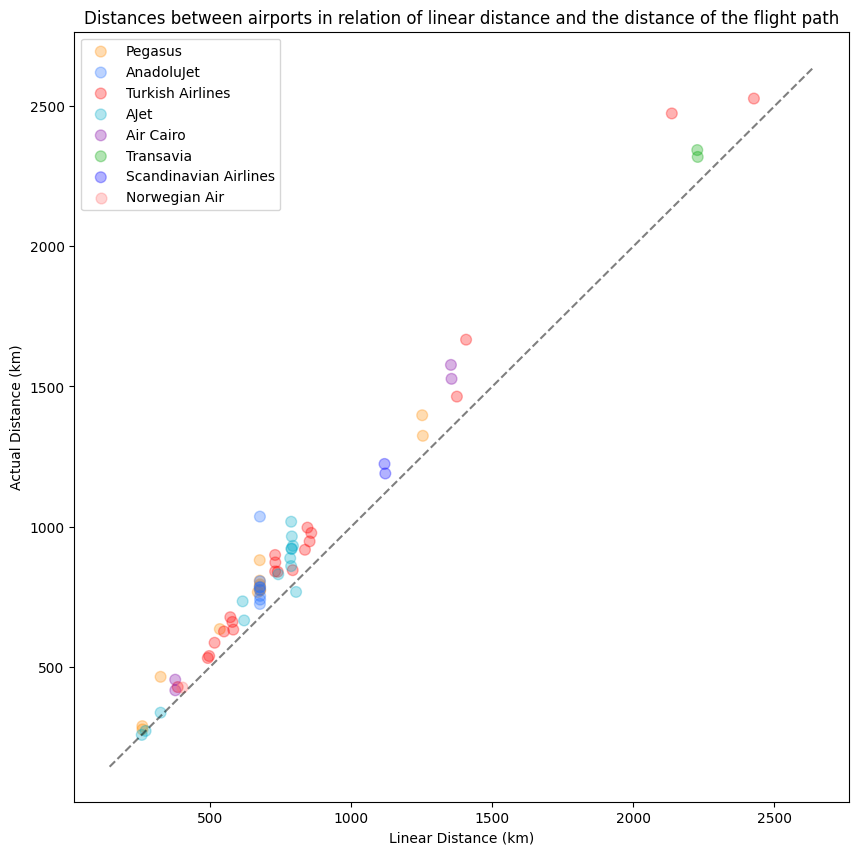

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
for a in diary['Airline'].unique():
    scatterthis = diary[(diary['Airline']==a)]
    ax.scatter(scatterthis['LinearDistance'], scatterthis['ActualDistance'], alpha=0.3, s=60, label=a, c=scatterthis['AirlineColor'])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
ax.plot(lims, lims, 'k--', alpha=0.5)
ax.set_xlabel('Linear Distance (km)')
ax.set_ylabel('Actual Distance (km)')
ax.set_title('Distances between airports in relation of linear distance and the distance of the flight path')
ax.legend()
plt.show()

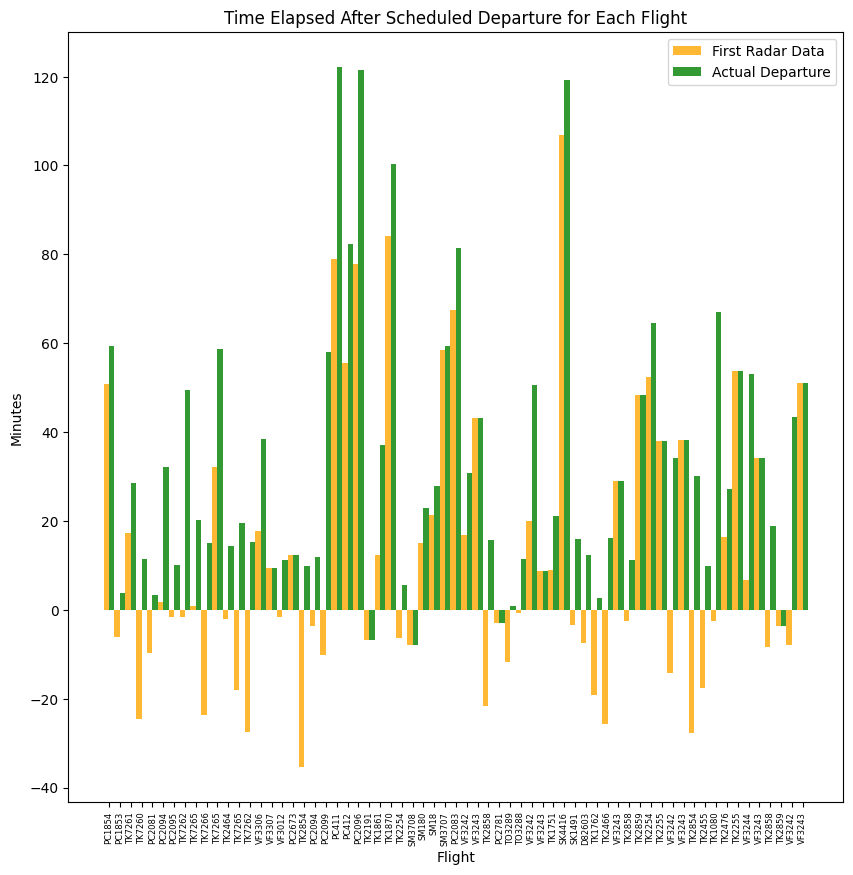

In [77]:
plottableflights = diary.copy()
plottableflights = plottableflights.dropna(subset=['LinearDistance', 'ActualDistance', 'FlightTime'])
plottableflights["FirstOnRadar"] = plottableflights["FirstOnRadar"].astype(int)
plottableflights["ActualDeparture"] = plottableflights["ActualDeparture"].astype(int)
plottableflights["ActualArrival"] = plottableflights["ActualArrival"].astype(int)
plottableflights["LastOnRadar"] = plottableflights["LastOnRadar"].astype(int)
plottableflights["FlightTime"] = plottableflights["FlightTime"].astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
x = np.arange(len(plottableflights))
ax.bar(x - 0.25, (plottableflights['FirstOnRadar']-plottableflights['Departure'])/60, 0.5, label='First Radar Data', alpha=0.8, color="#ffa600")
ax.bar(x + 0.25, (plottableflights['ActualDeparture']-plottableflights['Departure'])/60, 0.5, label='Actual Departure', alpha=0.8, color="green")
ax.set_xlabel('Flight')
ax.set_ylabel('Minutes')
ax.set_title('Time Elapsed After Scheduled Departure for Each Flight')
ax.set_xticks(x)
ax.set_xticklabels(plottableflights['FlightNumber'], rotation=90, fontsize=6)
ax.legend()

plt.show()

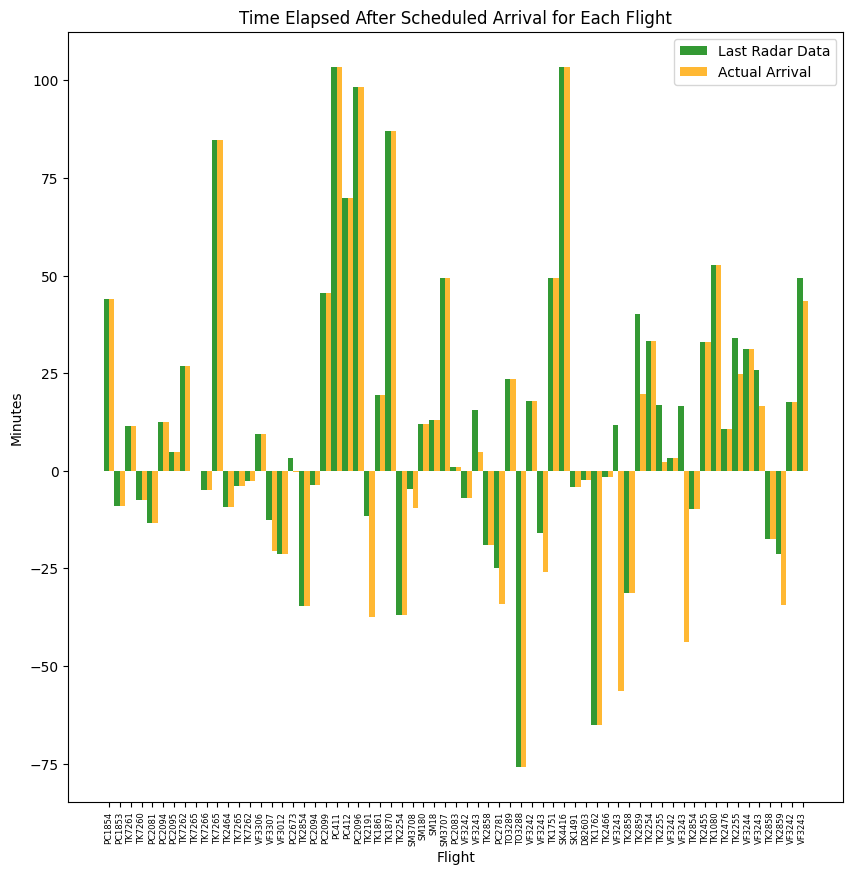

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))
x = np.arange(len(plottableflights))
ax.bar(x - 0.25, (plottableflights['LastOnRadar']-plottableflights['Arrival'])/60, 0.5, label='Last Radar Data', alpha=0.8, color="green")
ax.bar(x + 0.25, (plottableflights['ActualArrival']-plottableflights['Arrival'])/60, 0.5, label='Actual Arrival', alpha=0.8, color="#ffa600")
ax.set_xlabel('Flight')
ax.set_ylabel('Minutes')
ax.set_title('Time Elapsed After Scheduled Arrival for Each Flight')
ax.set_xticks(x)
ax.set_xticklabels(plottableflights['FlightNumber'], rotation=90, fontsize=6)
ax.legend()
plt.show()

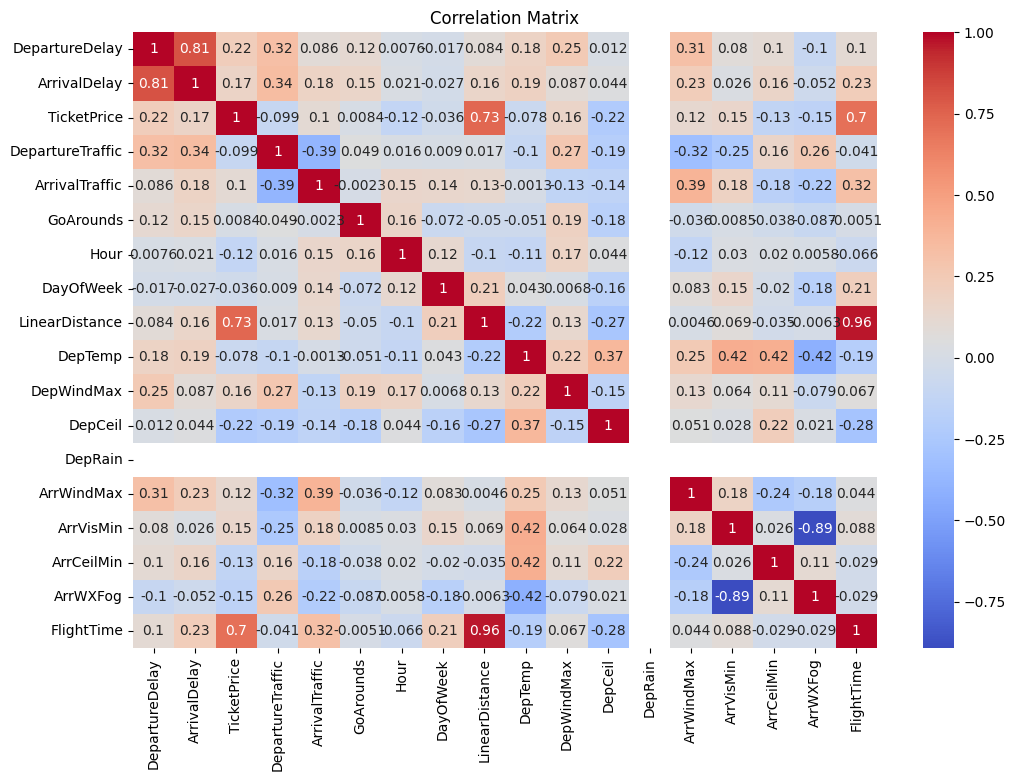

In [81]:
plt.figure(figsize=(12, 8))
sns.heatmap(diary[["DepartureDelay","ArrivalDelay","TicketPrice","DepartureTraffic","ArrivalTraffic","GoArounds","Hour","DayOfWeek","LinearDistance","DepTemp","DepWindMax","DepCeil","DepRain","ArrWindMax","ArrVisMin","ArrCeilMin","ArrWXFog","FlightTime"]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()